In [13]:
# https://photutils.readthedocs.io/en/stable/aperture.html#aperture-photometry-using-sky-coordinates
import time
import glob
import importlib
import tempfile
import numpy as np
import xarray as xr
import astropy
import astropy.io.fits as fits
from astropy.table import Table
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

from astro import astroutils
from astro import mastrometry
from astro import mimage
from astro import mphot

from utils import mutils
from utils import mlogging 

from astro.astroutils import jd2UTCtimestamp, UTCtimestamp2jd

%matplotlib ipympl

1041.264968603768 1359.8571172611355


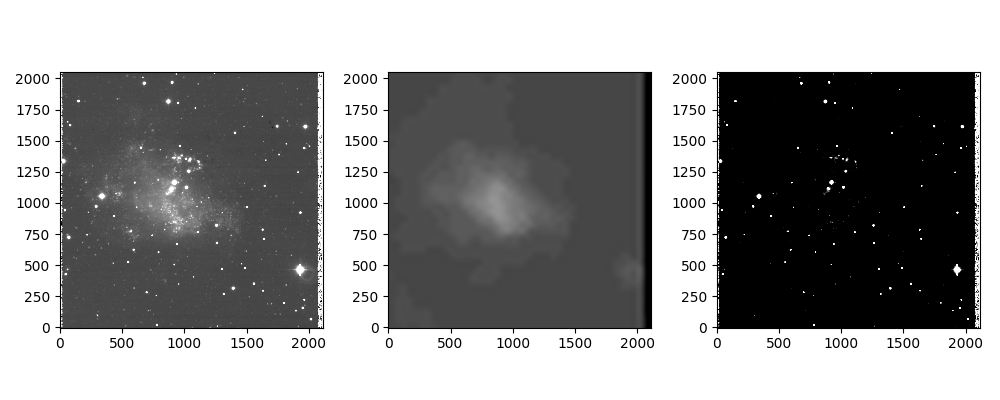

In [16]:
fn = r'/Users/canis/dev/holmberg/data/test/calibrated/g21d018.050.a.fits'
hdu = fits.open(fn)[1]
image = hdu.data
target= ('08 19 28.99', '70 42 19.4') # SIMBAD values is correct
comps = [     
            ('08 19 35.27861', '70 42 46.68284'), # A=1774 SNR=592   stdev = 0.2 (previously #1)  
            ('08 19 42.614',   '70 40 23.9842'),    # A=4800 SNR=1078 stdev = 0.05 (previously #5)
            ('08 19 57.87424', '70 42 53.07892'),   # A=2295 SNR=775 stdev = 0.03 (previously #6)
            ('08 19 33.91390', '70 44 27.99391'),   # A=3500 SNR=904      
            ('08 19 15.57437', '70 44 42.37452'),   # A=2014 SNR=637.7
        ]

x_t, y_t = mphot.equatorial2pix(target, fn)
print(x_t, y_t)

sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()

bg = Background2D(image, (50, 50), filter_size=(3, 3), 
        sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
plt.figure(figsize=(10,4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', origin='lower', vmin=10, vmax=50)
plt.subplot(1, 3, 2)
plt.imshow(bg.background, cmap='gray', origin='lower', vmin=10, vmax=50)
plt.subplot(1, 3, 3)
plt.imshow(image-bg.background, cmap='gray', origin='lower', vmin=10, vmax=50)
plt.tight_layout()

In [ ]:
plt.figure()
subimage = image[int(y_t)-10:int(y_t)+10, int(x_t)-10:int(x_t)+10]
plt.imshow(subimage)
bg = Background2D(subimage, box_size=5)
plt.figure()
plt.imshow(bg.background)
plt.figure()
plt.imshow(subimage-bg.background)

In [ ]:
dr=3.8
bw=7
sa=15
saturation=28000
cntrds = mphot.aperphot(sorted(glob.glob(f'/Users/canis/dev/holmberg/data/test/calibrated/*.fits')), startcoords=target,
                                compcoords=comps, ncompmax=5, snrmin=100,
                                diskradius=dr, bufferwidth=bw, skyannulus=sa,
                                Nthresh=2.4, autoradius='fixed', emax=0.5,
                                saturation=saturation,
                                nhist=1, quick='noctrd', maxcpus=None, verbose=True)
cntrds

In [ ]:
seeing = [np.mean(cntrds[i][8][1:].data) * .3252 for i in range(len(cntrds))]
seeing

DAOFIND

In [ ]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
bkg_sigma = mad_std(image)  
daofind = DAOStarFinder(fwhm=15, threshold=100)  
sources = daofind(image)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)
from photutils.aperture import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=4.)  
phot_table = aperture_photometry(image, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)  

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(image, cmap='gray', origin='lower', vmin=10, vmax=80)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
pass

In [ ]:
position = (22.007402, 39.008661)
aperture = CircularAperture(position, r=4.)
plt.figure()
plt.imshow(image, cmap='gray', origin='lower', vmin=10, vmax=80)
aperture.plot(color='blue', lw=1.5, alpha=0.5)

In [ ]:
from photutils.background import Background2D
bg = Background2D(image, box_size=5)
plt.figure()
aperture.plot(color='blue', lw=1.5, alpha=0.5)
plt.imshow(bg.background, cmap='gray', origin='lower', vmin=10, vmax=80)
plt.figure()
plt.imshow(image - bg.background, cmap='gray', origin='lower', vmin=0)
aperture.plot(color='blue', lw=1.5, alpha=0.5)